In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import pickle
import xgboost as xgb

In [0]:
# If on google chrome, upload the file here.
from google.colab import files
import io
files.upload()

In [4]:
# If on firefox or google chrome, open the sidebar, go to "files" tab, and upload there.
all_games_info = pd.read_csv("all_game_info.csv")
all_games_info.head()

,game_name,away,away_C_2PM,away_C_2PX,away_C_3PM,away_C_3PX,away_C_PASS,away_C_POSS,away_C_TO,away_PF_2PM,...,home_SF_POSS,home_SF_TO,home_SG_2PM,home_SG_2PX,home_SG_3PM,home_SG_3PX,home_SG_PASS,home_SG_POSS,home_SG_TO,home_points
0,2017-03-08-NYK-MIL.csv,NYK,4.0,3.50,0.0,0.00,35.50,45.0,3.5,1.75,...,79.0,1.0,2.0,2.0,2.00,2.333333,33.333333,40.666667,0.333333,82
1,2017-01-17-DAL-CHI.csv,DAL,2.0,0.50,0.0,0.50,14.00,15.0,0.5,3.00,...,75.0,3.0,5.0,8.0,0.50,2.000000,24.000000,39.000000,2.000000,80
2,2017-03-10-IND-MIL.csv,IND,2.0,3.25,0.0,0.25,18.75,22.5,0.5,5.00,...,81.0,6.0,2.0,2.5,1.25,1.500000,30.500000,38.750000,1.750000,73
3,2016-11-27-HOU-POR.csv,HOU,6.5,3.00,0.0,0.00,28.00,31.0,0.5,2.50,...,26.0,0.0,2.0,3.0,2.00,1.000000,23.500000,29.000000,1.500000,92
4,2016-03-23-DAL-POR.csv,DAL,4.0,4.50,0.0,0.00,20.00,25.5,2.5,4.00,...,31.0,0.5,1.5,1.5,1.00,1.000000,13.500000,19.000000,0.500000,77


In [0]:
def setup_train_test(games_info: pd.core.frame.DataFrame):
    if games_info is None:
        raise ValueError("Please pass the pandas dataframe")
        
    atts_to_exclude = ['home','away','game_name', 'away_points','home_points']
    atts_to_exclude += [col for col in games_info.columns.values if "PM" in col]

    train_df = games_info.sample(frac=0.8)    # split into training and testing
    test_df = games_info.drop(train_df.index)

    x_train = train_df.drop(atts_to_exclude,axis=1)
    x_test = test_df.drop(['away_points','home_points']+atts_to_exclude,axis=1)
    y_train_home = train_df['home_points']
    y_train_away = train_df['away_points']
    
    return (x_train, x_test, y_train_home, y_train_away, test_df)

In [16]:
x_train, x_test, y_train_home, y_train_away, test_df = setup_train_test(all_games_info)
print("# of unique end scores:", len(np.unique(y_train_home)))
print("Array:", np.unique(y_train_home))

# of unique end scores: 85
Array: [ 47  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 125 126 127 129
 130 131 132 134 136 137 138 140 141 143 146 147 148]


In [0]:
# Train and test using the archived files provided in the repository

h_classifier = pickle.load(open("home_classifier.pickle.dat", "rb"))
a_classifier = pickle.load(open("away_classifier.pickle.dat", "rb"))
test_df = pd.read_csv("test_data.csv")
test_df.head()
atts_to_exclude = ['home','away','game_name', 'away_points','home_points']
atts_to_exclude += [col for col in all_games_info.columns.values if "PM" in col]
x_test = test_df.drop(atts_to_exclude,axis=1)

In [0]:
def generate_classifiers(x_train, x_test, y_train_home, y_train_away):
    home_classifier = xgb.XGBClassifier(n_estimators = 300, n_jobs = -1, verbosity = 0, learning_rate = 0.1)
    away_classifier = xgb.XGBClassifier(n_estimators = 300, n_jobs = -1, verbosity = 0, learning_rate = 0.1)
 
    
    home_classifier.fit(x_train, y_train_home)
    away_classifier.fit(x_train, y_train_away)
    
    return (home_classifier, away_classifier)

In [0]:
# Train it yourself
h_classifier, a_classifier = generate_classifiers(x_train, x_test, y_train_home, y_train_away)

In [0]:
def generate_results(games_info, home_predictions, away_predictions):
    def calculate_loss(results_dict: dict):
        for stats in results_dict.values():
            stats["home_loss"] = (stats["home_points_predicted"] -
                                     stats["home_points_actual"])
            stats["away_loss"] = (stats["away_points_predicted"] -
                                     stats["away_points_actual"])

    results = pd.DataFrame({'game_name': games_info.game_name,
                        'home_points_predicted': home_predictions,
                        'away_points_predicted': away_predictions,
                        'home_points_actual': games_info.home_points,
                        'away_points_actual': games_info.away_points})
    results_dict = results.to_dict("index")
    calculate_loss(results_dict)
    results = pd.DataFrame(results_dict).transpose()
    
    return results.sort_values(by=["game_name", "home_loss", "away_loss"]).reset_index()[["game_name",
                                              "home_points_predicted",
                                              "home_points_actual",
                                              "home_loss",
                                              "away_points_predicted",
                                              "away_points_actual",
                                              "away_loss"]]

In [20]:
h_predictions = h_classifier.predict(x_test)
a_predictions = a_classifier.predict(x_test)
results = generate_results(test_df, h_predictions, a_predictions)
results.head()

,game_name,home_points_predicted,home_points_actual,home_loss,away_points_predicted,away_points_actual,away_loss
0,2016-02-01-MIL-SAC.csv,87,87,0,92,92,0
1,2016-02-01-TOR-DEN.csv,112,112,0,54,54,0
2,2016-02-02-MIL-POR.csv,115,89,26,82,81,1
3,2016-02-02-MIN-LAL.csv,84,92,-8,90,96,-6
4,2016-02-02-TOR-PHX.csv,109,109,0,56,56,0


In [0]:
import matplotlib.pyplot as plt
from statistics import mean
import numpy as np
def graph_scores(results, side: str = "home"):
    if side != "home" and side != "away":
        raise ValueError("Please select either 'home' or 'away'")
    plt.scatter(results.index, results[side + "_loss"])
    plt.xlabel("games")
    plt.ylabel(side + " loss")
    plt.title(side + " loss vs games")
    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False
    )
    plt.axhline(y=0, color='r')
    plt.tight_layout()
    plt.show()

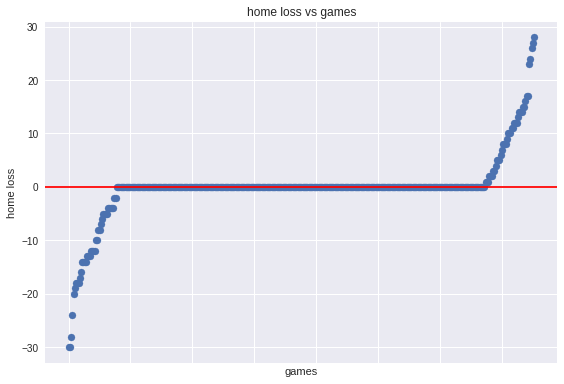

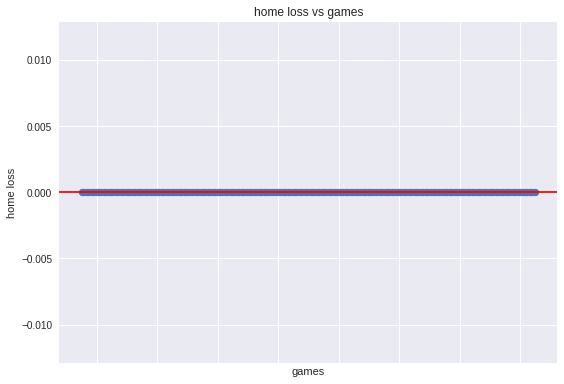

In [22]:
graph_scores(results.sort_values(by=["home_loss"]).reset_index(), side="home")
graph_scores(results.sort_values(by=["home_loss"]).reset_index()[int(.25*len(results)):int(.75*len(results))], side="home")

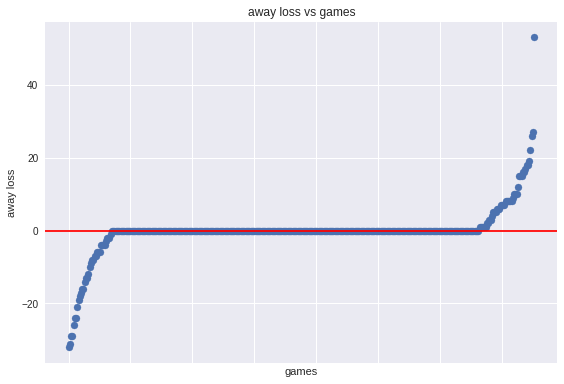

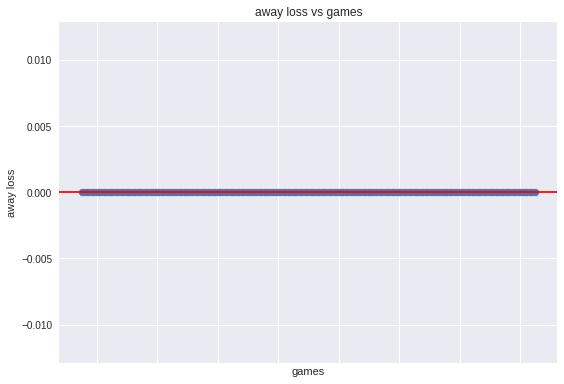

In [23]:
graph_scores(results.sort_values(by=["away_loss"]).reset_index(), side="away")
graph_scores(results.sort_values(by=["away_loss"]).reset_index()[int(.25*len(results)):int(.75*len(results))], side="away")

In [24]:
print(mean(results["home_loss"]))
print(mean(results["away_loss"]))
print(mean_absolute_error(results["home_points_actual"], results["home_points_predicted"]))
print(mean_absolute_error(results["away_points_actual"], results["away_points_predicted"]))

-0.11405835543766578
0.026525198938992044
2.40053050397878
2.3978779840848805


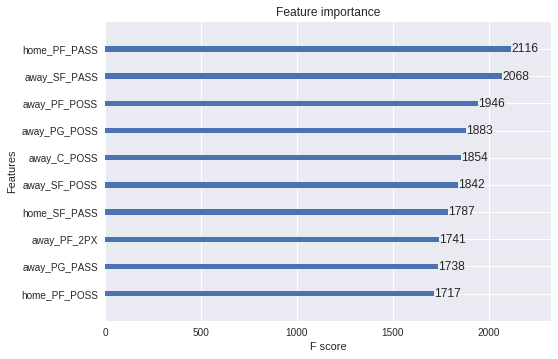

In [25]:
xgb.plot_importance(a_classifier, max_num_features=10)

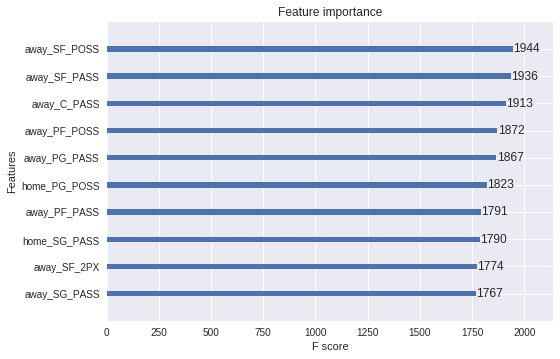

In [26]:
xgb.plot_importance(h_classifier, max_num_features=10)

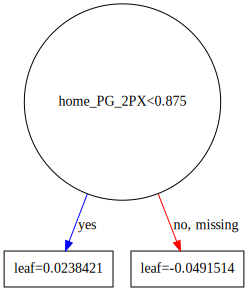

In [27]:
xgb.to_graphviz(h_classifier)

In [0]:
def calculate_softmax_values(logits):
    exps = [np.exp(logit) for logit in logits]
    exp_sum = sum(exps)
    return [exp/exp_sum for exp in exps]

In [29]:
softmax = calculate_softmax_values([0.0238421, -0.0491514])
print(softmax)
print(sum(softmax))

[0.5182402769585307, 0.4817597230414694]
1.0


In [0]:
def determine_winner(results):
    game_names = []
    home_winner_pred = []
    home_winner_actual = []
    
    for row in results.itertuples():
        game_names.append(row.game_name)
        
        home_winner_pred.append(row.home_points_predicted > row.away_points_predicted)
        home_winner_actual.append(row.home_points_actual > row.away_points_actual)
        
    return pd.DataFrame({"game_name": game_names, "home_win_prediction":
                         home_winner_pred, "home_win_actual":
                         home_winner_actual})

In [31]:
win_vals = determine_winner(results)
win_vals.head()

,game_name,home_win_actual,home_win_prediction
0,2016-02-01-MIL-SAC.csv,False,False
1,2016-02-01-TOR-DEN.csv,True,True
2,2016-02-02-MIL-POR.csv,True,True
3,2016-02-02-MIN-LAL.csv,False,False
4,2016-02-02-TOR-PHX.csv,True,True


In [32]:
print(accuracy_score(win_vals["home_win_actual"], win_vals["home_win_prediction"]))

0.9177718832891246


In [0]:
pickle.dump(h_classifier, open("home_classifier.pickle.dat", "wb"))
pickle.dump(h_classifier, open("away_classifier.pickle.dat", "wb"))
h_classifier.get_booster().dump_model('home_trees.txt')
a_classifier.get_booster().dump_model('away_trees.txt')
test_df.sort_values(by=['game_name']).to_csv('test_data.csv', index=False)